# 22.11.5362 - Aprilla Daru
# 22.11.5325 - Rasendria Danbelva F
# 22.11.4882 - Vatika Juniar kariyono
# 22.11.5264 - Sila Cahya Dewi
# 22.11.5343 - Aldi Krisnanda Putra

dataset : https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification/data

# PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier, OneVsRest
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
spark = SparkSession.builder \
    .appName("Fetal Health Classification") \
    .getOrCreate()

data = spark.read.csv("/content/fetal_health.csv", header=True, inferSchema=True)
data.show(5)

+--------------+-------------+--------------+--------------------+-------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+---------------+-------------+-------------+-------------------------+--------------------------+--------------+--------------+----------------+------------------+------------------+------------+
|baseline value|accelerations|fetal_movement|uterine_contractions|light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|histogram_width|histogram_min|histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|histogram_mode|histogram_mean|histogram_median|histogram_variance|histogram_tendency|fetal_health|
+--------------+--------

In [ ]:
data.printSchema()

root
 |-- baseline value: double (nullable = true)
 |-- accelerations: double (nullable = true)
 |-- fetal_movement: double (nullable = true)
 |-- uterine_contractions: double (nullable = true)
 |-- light_decelerations: double (nullable = true)
 |-- severe_decelerations: double (nullable = true)
 |-- prolongued_decelerations: double (nullable = true)
 |-- abnormal_short_term_variability: double (nullable = true)
 |-- mean_value_of_short_term_variability: double (nullable = true)
 |-- percentage_of_time_with_abnormal_long_term_variability: double (nullable = true)
 |-- mean_value_of_long_term_variability: double (nullable = true)
 |-- histogram_width: double (nullable = true)
 |-- histogram_min: double (nullable = true)
 |-- histogram_max: double (nullable = true)
 |-- histogram_number_of_peaks: double (nullable = true)
 |-- histogram_number_of_zeroes: double (nullable = true)
 |-- histogram_mode: double (nullable = true)
 |-- histogram_mean: double (nullable = true)
 |-- histogram_medi

In [ ]:
new_column_names = [
    "baseline_value", "accelerations", "fetal_movement", "uterine_contractions", "light_decelerations",
    "severe_decelerations", "prolongued_decelerations", "abnormal_short_term_variability",
    "mean_value_of_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability",
    "mean_value_of_long_term_variability", "histogram_width", "histogram_min", "histogram_max",
    "histogram_number_of_peaks", "histogram_number_of_zeroes", "histogram_mode", "histogram_mean",
    "histogram_median", "histogram_variance", "histogram_tendency", "fetal_health"
]
data = data.toDF(*new_column_names)

In [ ]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+--------------+-------------+--------------+--------------------+-------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+---------------+-------------+-------------+-------------------------+--------------------------+--------------+--------------+----------------+------------------+------------------+------------+
|baseline_value|accelerations|fetal_movement|uterine_contractions|light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|histogram_width|histogram_min|histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|histogram_mode|histogram_mean|histogram_median|histogram_variance|histogram_tendency|fetal_health|
+--------------+--------

In [ ]:
data.describe().show()

+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+-------------------------------+------------------------------------+------------------------------------------------------+-----------------------------------+------------------+------------------+------------------+-------------------------+--------------------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|   baseline_value|       accelerations|      fetal_movement|uterine_contractions| light_decelerations|severe_decelerations|prolongued_decelerations|abnormal_short_term_variability|mean_value_of_short_term_variability|percentage_of_time_with_abnormal_long_term_variability|mean_value_of_long_term_variability|   histogram_width|     histogram_min|     histogram_max|histogram_number_of_peaks|histogram_number_of_zeroes|    histogram_mode|    histogr

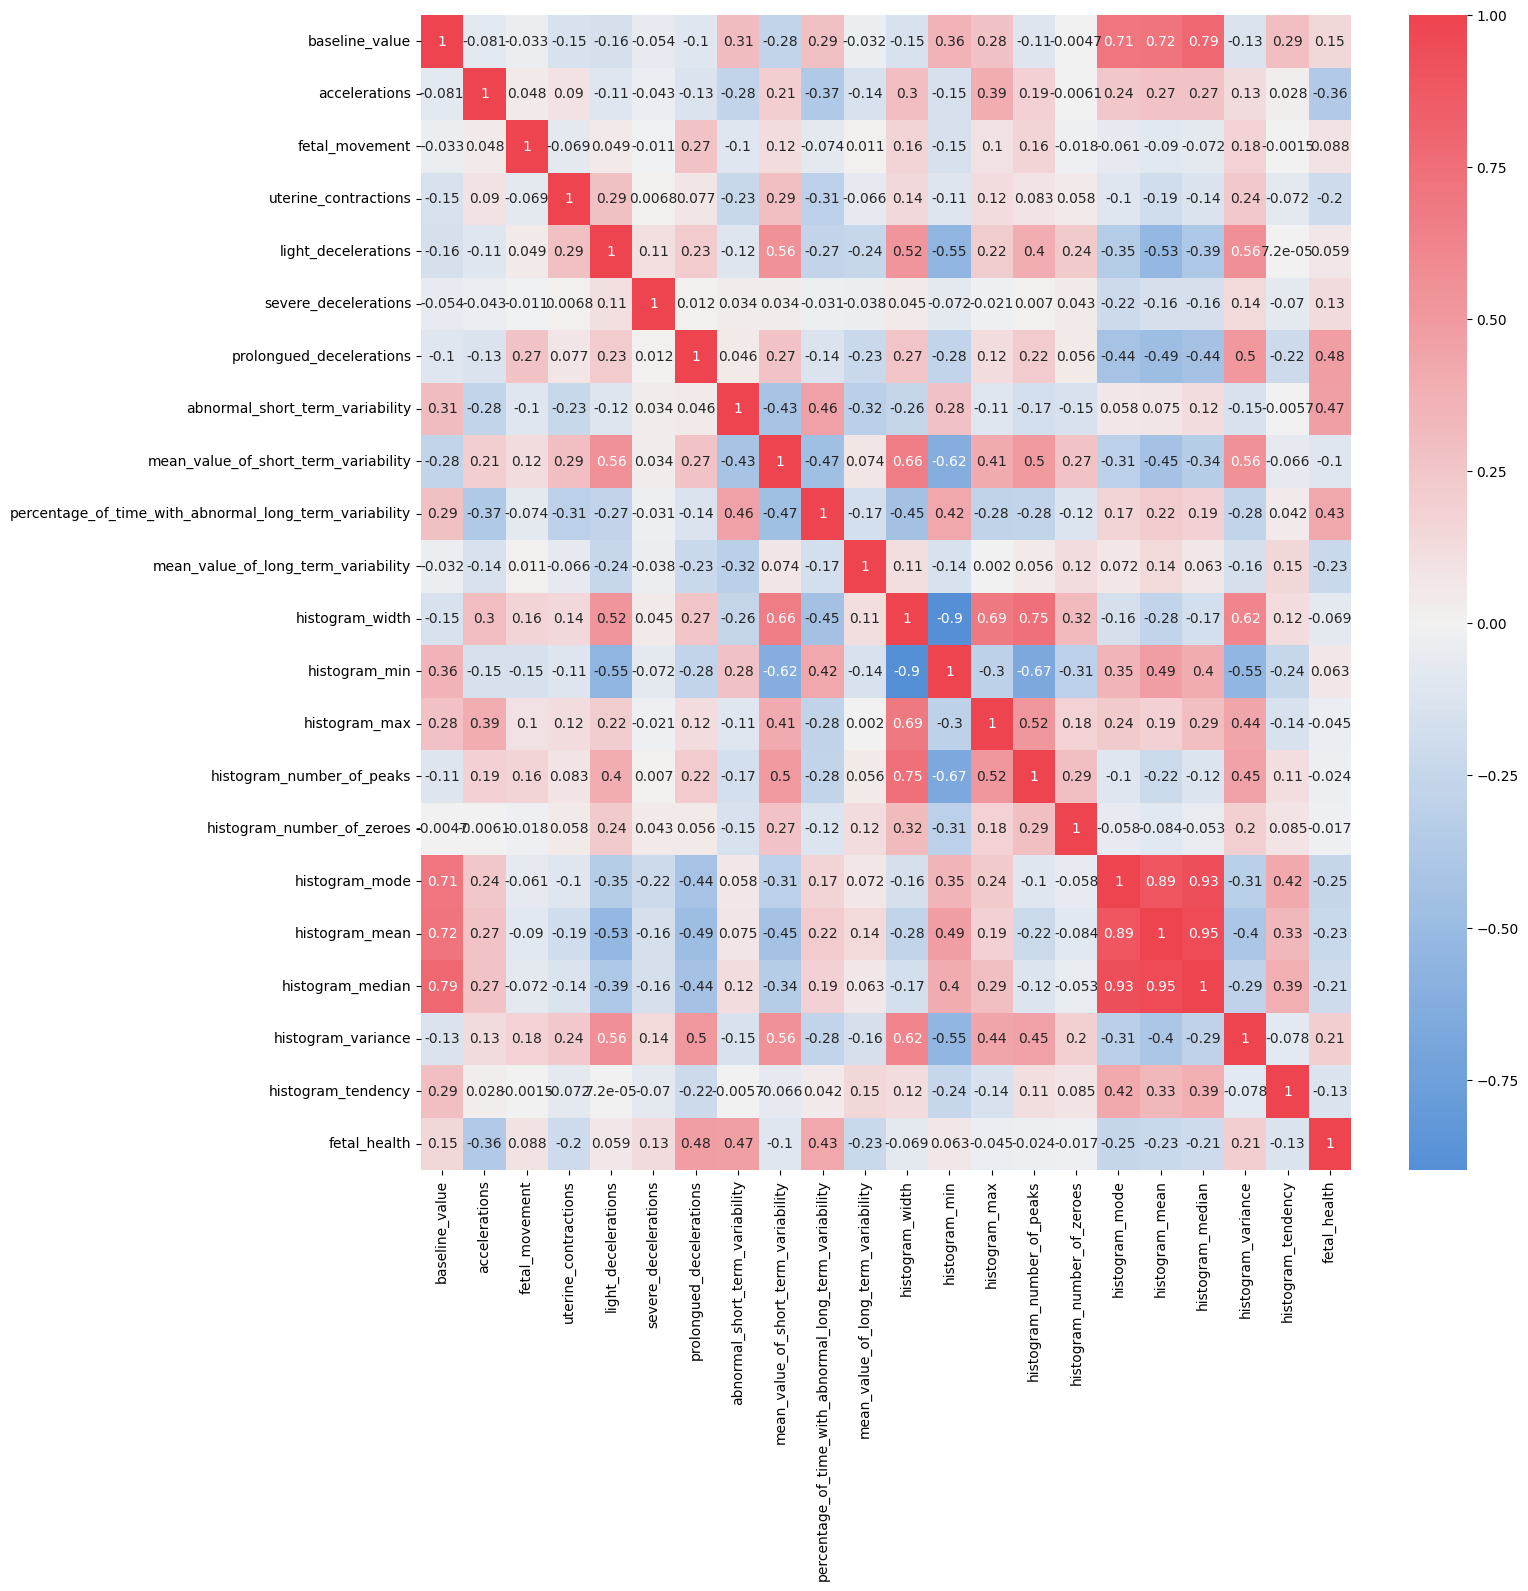

In [ ]:
pandas_data = data.toPandas()
corrmat = pandas_data.corr()
plt.figure(figsize=(15, 15))
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.show()

<ipython-input-8-1f338b16c7ec>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_data, x="fetal_health", palette='pastel')


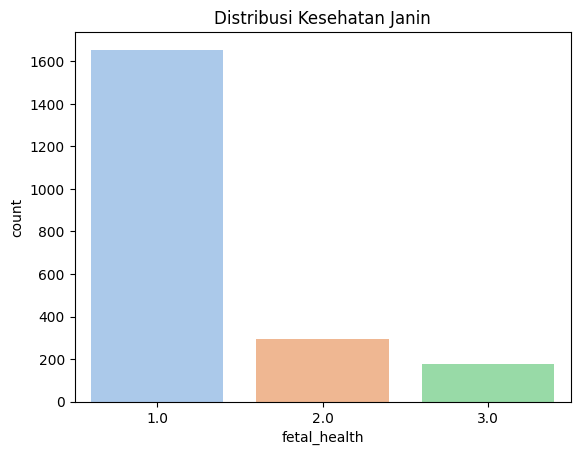

In [ ]:
sns.countplot(data=pandas_data, x="fetal_health", palette='pastel')
plt.title("Distribusi Kesehatan Janin")
plt.show()

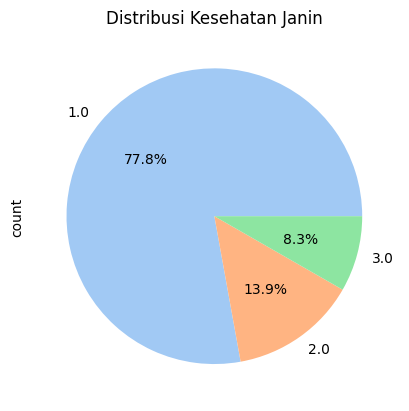

In [ ]:
pandas_data['fetal_health'].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette('pastel'))
plt.title("Distribusi Kesehatan Janin")
plt.show()

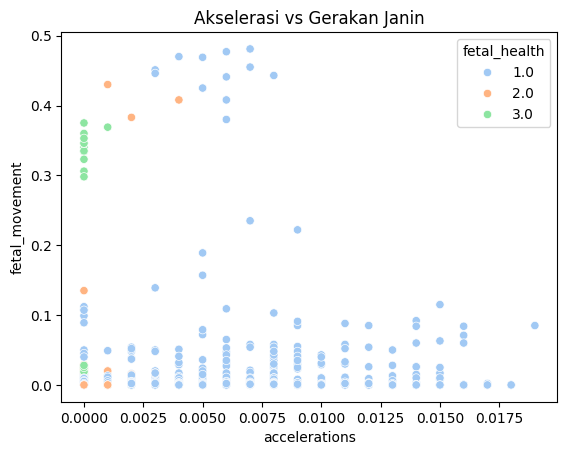

In [ ]:
sns.scatterplot(data=pandas_data, x="accelerations", y="fetal_movement", hue="fetal_health", palette='pastel')
plt.title("Akselerasi vs Gerakan Janin")
plt.show()

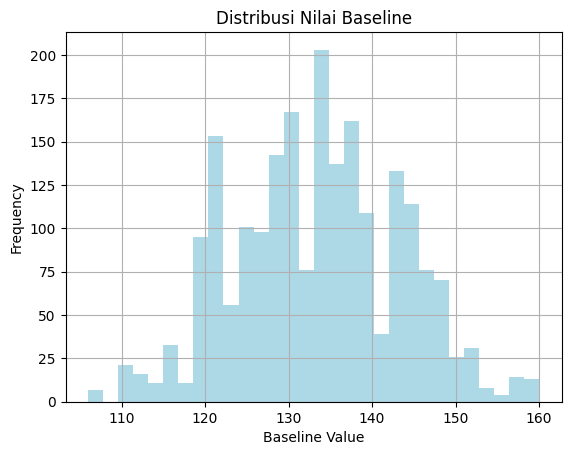

In [ ]:
pandas_data["baseline_value"].hist(bins=30, color='lightblue')
plt.title("Distribusi Nilai Baseline")
plt.xlabel("Baseline Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
feature_columns = [
    "baseline_value", "accelerations", "fetal_movement", "uterine_contractions", "light_decelerations",
    "severe_decelerations", "prolongued_decelerations", "abnormal_short_term_variability",
    "mean_value_of_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability",
    "mean_value_of_long_term_variability", "histogram_width", "histogram_min", "histogram_max",
    "histogram_number_of_peaks", "histogram_number_of_zeroes", "histogram_mode", "histogram_mean",
    "histogram_median", "histogram_variance", "histogram_tendency"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

In [ ]:
lr = LogisticRegression(labelCol="fetal_health", featuresCol="scaledFeatures")
dt = DecisionTreeClassifier(labelCol="fetal_health", featuresCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="fetal_health", featuresCol="scaledFeatures")
gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="fetal_health")

In [ ]:
ovr_gbt = OneVsRest(classifier=gbt, labelCol="fetal_health")

In [ ]:
pipelines = [
    Pipeline(stages=[assembler, scaler, lr]),
    Pipeline(stages=[assembler, scaler, dt]),
    Pipeline(stages=[assembler, scaler, rf]),
    Pipeline(stages=[assembler, scaler, ovr_gbt])
]

In [ ]:
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedRecall")

In [ ]:
for pipeline in pipelines:
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    accuracy = accuracy_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)

    model_name = pipeline.getStages()[-1].__class__.__name__
    print(f"Model: {model_name}, Accuracy: {accuracy}, F1 Score: {f1_score}, Precision: {precision}, Recall: {recall}")

    if isinstance(pipeline.getStages()[-1], OneVsRest):
        for label in data.select("fetal_health").distinct().collect():
            label_value = label.fetal_health
            binary_predictions = predictions.withColumn("binary_prediction", when(col("prediction") == label_value, 1).otherwise(0))
            binary_evaluator = BinaryClassificationEvaluator(labelCol="binary_prediction", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
            auc = binary_evaluator.evaluate(binary_predictions)
            print(f"AUC for class {label_value}: {auc}")

Model: LogisticRegression, Accuracy: 0.8831615120274914, F1 Score: 0.8832436637784311, Precision: 0.8839772732411699, Recall: 0.8831615120274914
Model: DecisionTreeClassifier, Accuracy: 0.9140893470790378, F1 Score: 0.910909554401392, Precision: 0.9122126788360738, Recall: 0.9140893470790379
Model: RandomForestClassifier, Accuracy: 0.915807560137457, F1 Score: 0.9112096717247294, Precision: 0.9136248012990276, Recall: 0.915807560137457
Model: OneVsRest, Accuracy: 0.9192439862542955, F1 Score: 0.9191397400403815, Precision: 0.9191845870413162, Recall: 0.9192439862542955
AUC for class 1.0: 0.9986209035122079
AUC for class 3.0: 0.07052877436152699
AUC for class 2.0: 0.05933632654921715


In [ ]:
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
gbt_pipeline = Pipeline(stages=[assembler, scaler, ovr_gbt])

In [ ]:
# Random Forest
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .build()

# Gradient Boosting
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="accuracy")

rf_crossval = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=3)
rf_cvModel = rf_crossval.fit(train_data)

rf_predictions = rf_cvModel.transform(test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Best Model Accuracy after Tuning: {rf_accuracy}")

gbt_crossval = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=gbt_paramGrid, evaluator=evaluator, numFolds=3)
gbt_cvModel = gbt_crossval.fit(train_data)

gbt_predictions = gbt_cvModel.transform(test_data)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting Best Model Accuracy after Tuning: {gbt_accuracy}")

Random Forest Best Model Accuracy after Tuning: 0.915807560137457
Gradient Boosting Best Model Accuracy after Tuning: 0.9192439862542955


In [ ]:
spark.stop()